In [42]:
from settrade_v2 import Investor
import psycopg2
import pandas as pd
import time
from psycopg2 import sql
from datetime import datetime
from pprint import pprint
import mplfinance as mpf
import matplotlib.pyplot as plt


In [52]:
from settrade_v2 import Investor
from pprint import pprint
investor = Investor(
                    app_id="94ZEzJG15yt9RnlP",
                    app_secret="bx4ZJ6dozvBmm8JaUpMBo7l3/AZ+aJ4tpq9GGAS8SLc=",
                    broker_id="SANDBOX",
                    app_code="SANDBOX",
                    is_auto_queue = False)

In [53]:
def get_quote_symbol(symbol):
    return f"Quote for {symbol}"

print(get_quote_symbol("AAPL"))

Quote for AAPL


In [54]:

deri = investor.Derivatives(account_no="mama-D")            

account_info = deri.get_account_info()

account_info                                              

{'creditLine': 2000000000.0,
 'excessEquity': 2000000000.0,
 'cashBalance': 2000000000.0,
 'equity': 2000000000.0,
 'totalMR': 0.0,
 'totalMM': 0.0,
 'totalFM': 0.0,
 'callForceFlag': 'No',
 'callForceMargin': 0.0,
 'liquidationValue': 2000000000.0,
 'depositWithdrawal': 0.0,
 'callForceMarginMM': 0.0,
 'initialMargin': 0.0,
 'closingMethod': 'Auto Net'}

In [55]:
# กรณี Investor
market = investor.MarketData()

In [56]:
res = market.get_candlestick(
symbol="GULF",
interval="1d",
limit=1,
normalized=True,
)
res

{'lastSequence': 327229,
 'time': [1740934800],
 'open': [55.0],
 'high': [57.5],
 'low': [40.0],
 'close': [57.5],
 'volume': [88700],
 'value': [4663500.0]}

In [65]:
db_config = {
    'dbname': 'technical_Data',
    'user': 'postgres',
    'password': 'admin',
    'host': 'localhost',
    'port': "5432"
}

In [69]:
# ✅ ฟังก์ชันแปลง timestamp (วินาที -> datetime)
def convert_timestamp(timestamp):
    """
    แปลง timestamp (วินาที) เป็น datetime ที่เหมาะสมสำหรับ PostgreSQL
    """
    return datetime.utcfromtimestamp(timestamp)

In [70]:
# ✅ ฟังก์ชันดึงข้อมูลแท่งเทียนจาก API และบันทึกลง PostgreSQL
def insert_candlestick_data(symbol, interval="1d", limit=10):
    try:
        print(f"🔍 กำลังดึงข้อมูลแท่งเทียนสำหรับ {symbol} (Interval: {interval})...")
        res = market.get_candlestick(
            symbol=symbol,
            interval=interval,
            limit=limit,
            normalized=True
        )

        print(f"📊 Response จาก API: {res}")  # ✅ Debug ดูข้อมูลจาก API

        # 🚨 ตรวจสอบว่าข้อมูลเป็น Dictionary และมี Key ที่ต้องการ
        if not isinstance(res, dict) or "time" not in res:
            print(f"⚠️ ข้อมูลแท่งเทียนของ {symbol} ไม่สามารถดึงได้ หรือ API ไม่รองรับ")
            return

        # 🔗 เชื่อมต่อฐานข้อมูล
        conn = psycopg2.connect(**db_config)
        cursor = conn.cursor()

        # 📌 คำสั่ง SQL สำหรับ INSERT
        insert_query = sql.SQL("""
            INSERT INTO stock_candlestick (
                symbol, interval, timestamp, open, high, low, close, volume, value, updated_at
            ) VALUES (
                %(symbol)s, %(interval)s, %(timestamp)s, %(open)s, %(high)s, %(low)s, %(close)s, %(volume)s, %(value)s, NOW()
            )
            ON CONFLICT (symbol, interval, timestamp) DO UPDATE SET
                open = EXCLUDED.open,
                high = EXCLUDED.high,
                low = EXCLUDED.low,
                close = EXCLUDED.close,
                volume = EXCLUDED.volume,
                value = EXCLUDED.value,
                updated_at = NOW();
        """)

        # 🔄 **แปลงข้อมูลจาก Dictionary ที่มี List ให้เป็น List ของ Dictionary**
        for i in range(len(res["time"])):
            data = {
                'symbol': symbol,
                'interval': interval,
                'timestamp': convert_timestamp(res["time"][i]),  # 🕒 ใช้ฟังก์ชัน convert_timestamp()
                'open': res["open"][i],
                'high': res["high"][i],
                'low': res["low"][i],
                'close': res["close"][i],
                'volume': res["volume"][i],
                'value': res["value"][i]
            }

            cursor.execute(insert_query, data)
            conn.commit()

        print(f"✅ ข้อมูลแท่งเทียนของ {symbol} (Interval: {interval}) ถูกบันทึกเรียบร้อยแล้ว!")

    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาดกับ {symbol}: {e}")

    finally:
        if 'cursor' in locals(): cursor.close()
        if 'conn' in locals(): conn.close()

In [71]:
# 🔄 ทดสอบกับหุ้น GULF
symbols = ["GULF"]
intervals = ["1d"]

for symbol in symbols:
    for interval in intervals:
        print(f"🔄 กำลังดึงข้อมูลสำหรับ {symbol} (Interval: {interval})...")
        insert_candlestick_data(symbol, interval=interval, limit=10)
        time.sleep(2)  # ⏳ ลด API Rate Limit

🔄 กำลังดึงข้อมูลสำหรับ GULF (Interval: 1d)...
🔍 กำลังดึงข้อมูลแท่งเทียนสำหรับ GULF (Interval: 1d)...
📊 Response จาก API: {'lastSequence': 327229, 'time': [1739811600, 1739898000, 1739984400, 1740070800, 1740330000, 1740416400, 1740502800, 1740589200, 1740675600, 1740934800], 'open': [58.0, 57.5, 56.25, 52.0, 52.5, 51.5, 50.0, 50.0, 47.25, 55.0], 'high': [58.25, 57.75, 56.5, 53.75, 52.75, 52.0, 51.5, 50.25, 49.5, 57.5], 'low': [57.25, 56.5, 51.25, 51.25, 50.0, 49.5, 50.0, 48.5, 46.75, 40.0], 'close': [58.0, 56.5, 51.25, 53.0, 51.5, 50.0, 50.5, 48.75, 49.0, 57.5], 'volume': [16657883, 16242013, 56109506, 34732837, 37309284, 25869840, 21494877, 33076222, 50207697, 88700], 'value': [963379877.75, 927103044, 2981780402.5, 1836023106.5, 1902953114.25, 1308737565, 1090509954.75, 1629515009.25, 2432404592.25, 4663500.0]}
✅ ข้อมูลแท่งเทียนของ GULF (Interval: 1d) ถูกบันทึกเรียบร้อยแล้ว!


C:\Users\Admin\AppData\Local\Temp\ipykernel_1908\3369442398.py:6: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(timestamp)


In [72]:
try:
    symbols_df = pd.read_csv("thai_stocks.csv")  # ไฟล์ต้องมีคอลัมน์ 'symbol'
    symbols = symbols_df['symbol'].dropna().tolist()
except FileNotFoundError:
    print("❌ ไม่พบไฟล์ 'thai_stocks.csv' ใช้รายชื่อหุ้นที่กำหนดแทน")
    symbols = ["PTT", "AOT", "SCB", "24CS"]

for symbol in symbols:
    for interval in intervals:
        insert_candlestick_data(symbol, interval=interval, limit=10)
        time.sleep(2)  # ⏳ ลด API Rate Limit


🔍 กำลังดึงข้อมูลแท่งเทียนสำหรับ 24CS (Interval: 1d)...
📊 Response จาก API: {'lastSequence': 0, 'time': [1739725200, 1739811600, 1739898000, 1739984400, 1740070800, 1740330000, 1740416400, 1740502800, 1740589200, 1740675600], 'open': [2.72, 2.52, 2.48, 2.6, 2.5, 2.56, 2.5, 2.52, 2.44, 2.3], 'high': [2.72, 2.54, 2.66, 2.64, 2.64, 2.56, 2.52, 2.54, 2.44, 2.3], 'low': [2.54, 2.44, 2.48, 2.58, 2.5, 2.48, 2.44, 2.46, 2.3, 2.0], 'close': [2.54, 2.48, 2.58, 2.58, 2.5, 2.5, 2.48, 2.48, 2.3, 2.14], 'volume': [1014101, 338760, 577907, 272500, 260200, 68901, 272650, 91201, 586601, 852397], 'value': [2651912.62, 845884.0, 1493344.26, 713212.0, 668404.0, 172076.56, 676959.0, 226722.48, 1392976.4, 1762223.7]}


C:\Users\Admin\AppData\Local\Temp\ipykernel_1908\3369442398.py:6: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(timestamp)


✅ ข้อมูลแท่งเทียนของ 24CS (Interval: 1d) ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูลแท่งเทียนสำหรับ 2S (Interval: 1d)...
📊 Response จาก API: {'lastSequence': 0, 'time': [1739725200, 1739811600, 1739898000, 1739984400, 1740070800, 1740330000, 1740416400, 1740502800, 1740589200, 1740675600], 'open': [2.46, 2.48, 2.36, 2.34, 2.4, 2.34, 2.32, 2.32, 2.32, 2.3], 'high': [2.48, 2.48, 2.36, 2.4, 2.4, 2.34, 2.32, 2.32, 2.34, 2.34], 'low': [2.46, 2.3, 2.32, 2.34, 2.32, 2.3, 2.32, 2.3, 2.3, 2.28], 'close': [2.46, 2.34, 2.34, 2.36, 2.36, 2.32, 2.32, 2.32, 2.34, 2.34], 'volume': [4631, 71767, 33322, 23695, 20229, 18331, 52015, 7176, 59735, 23655], 'value': [11412.88, 168896.02, 77880.2, 55827.9, 47541.54, 42518.56, 120675.4, 16527.42, 138498.38, 54358.21]}
✅ ข้อมูลแท่งเทียนของ 2S (Interval: 1d) ถูกบันทึกเรียบร้อยแล้ว!
🔍 กำลังดึงข้อมูลแท่งเทียนสำหรับ 3BBIF (Interval: 1d)...
📊 Response จาก API: {'lastSequence': 0, 'time': [1739725200, 1739811600, 1739898000, 1739984400, 1740070800, 1740330000, 174041640

In [75]:

# ✅ ฟังก์ชันดึงข้อมูลแท่งเทียนจาก PostgreSQL
def get_stock_data(symbol, interval="1d", limit=50):
    try:
        # 🔗 เชื่อมต่อฐานข้อมูล
        conn = psycopg2.connect(**db_config)
        query = f"""
            SELECT timestamp, open, high, low, close, volume 
            FROM stock_candlestick 
            WHERE symbol = '{symbol}' AND interval = '{interval}'
            ORDER BY timestamp DESC
            LIMIT {limit};
        """
        df = pd.read_sql(query, conn)
        conn.close()

        # 🚀 แปลงข้อมูล timestamp ให้เป็น index
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        return df

    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาด: {e}")
        return None

# 🔥 ดึงข้อมูลหุ้น PTT (แทนที่ด้วยหุ้นที่ต้องการ)
symbol = "GULF"
df = get_stock_data(symbol, interval="1d", limit=50)

# 📌 ตรวจสอบข้อมูลก่อนนำไปพลอต
print(df.head())  # แสดงข้อมูล 5 แถวแรก


                      open   high    low  close    volume
timestamp                                                
2025-03-02 17:00:00  55.00  57.50  40.00  57.50     88700
2025-02-27 17:00:00  47.25  49.50  46.75  49.00  50207697
2025-02-26 17:00:00  50.00  50.25  48.50  48.75  33076222
2025-02-25 17:00:00  50.00  51.50  50.00  50.50  21494877
2025-02-24 17:00:00  51.50  52.00  49.50  50.00  25869840


C:\Users\Admin\AppData\Local\Temp\ipykernel_1908\383011758.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


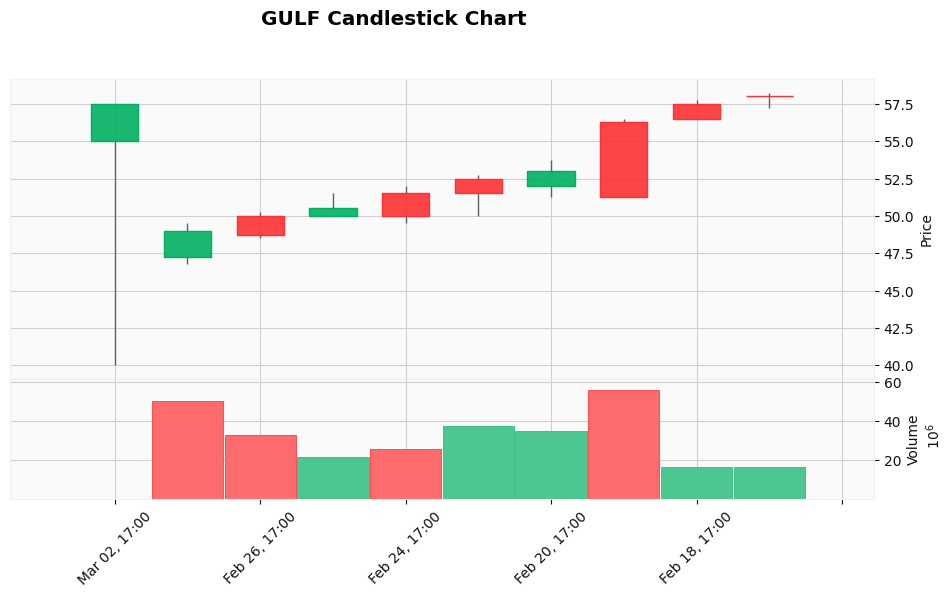

In [76]:
# 📊 ถ้ามีข้อมูล ให้แสดงกราฟ
if df is not None and not df.empty:
    mpf.plot(df, type='candle', volume=True, style='yahoo', title=f"{symbol} Candlestick Chart",
             ylabel="Price", ylabel_lower="Volume", figsize=(12,6))
    plt.show()
else:
    print("⚠️ ไม่มีข้อมูลเพียงพอสำหรับสร้างกราฟ")
